In [1]:
import gymnasium as gym
import torch.nn as nn
import torch.optim as optim 
import numpy as np
import torch

### Q value algorithm
+ the basic idea of Q value (value function) is to calculate the value of a given state, with an action at step t using its reward and state value of the next step as the consequence of the action at step t.
  + Q($s_t$, $a_t$) = $r_{t+1}$ + gamma * max(Q($s_{t+1}$, $a_{t+1}$)). The right side is called TD target
  + The bellman implementation is based on iterative conversion using a learning rate alpha
    + $Q_{new}$($s_t$, $a_t$)                                       
       = (1-alpha)* $Q_{old}$($s_t$, $a_t$) + alpha * ($r_{t+1} + gamma * max($Q_{old}$($s_{t+1}$, $a{t+1}$)))
      
+ in deep RL, instead of using the iterative process, we use a deep neural network to learn for a given input state, its output corresponding to each possible action
  + the input has the dimension of the state dimension, and output has the dimension of number of actions
  + a good example is the LunarLander environment from gym where a state is defined as an eight-dimension vector corresponding to x position, y position, x velocity, y velocity, lander angle, angle velocity, left foot contacts with land (yes/no as 1/0) and right foot contacts with land (yes/no as 1/0)
  + for NN network, input_dimension and output_dimensions are 8 and 4 (up, down, left, right) respectively
#### Barebone Deep Q-network (DQN)
+ selection actions
  + select the action with maximum output
+ loss function
   + instead of iterative process, the loss is directly defined as TD target minus Q-value at (s, a) as below:
     + [($r_{t+1}$ + gamma * max(Q($s_{t+1}$, $a_{t+1}$))) - Q($s_t$, $a_t$)]$^2$
#### Experience Replay
+ consecutive experiences are highly correlated
+ use a replay buffer to store and randomly sample batches to learn from random batches of past experience 
#### Replay buffer
+ use a deque data structure to save a number of samples with a defined capacity
+ when extra samples are pushed to the buffer, it will replace the early samples (FIFO)
+ we can sample randomly by random.sample(buffer, batch_size) method
#### Fixed target network (DQN)
+ Q-Network in both Q-Value and TD-target calculation
+ instability from shifting target
+ introduce another target network, in addition to online network, to stabilize target
+ target network is first initialized to be equal to online network
  + then update from the state dict of online network for each batch
#### Double DQN (DDQN)
+ similar to classic Q-learning, DQN overestimates Q-values, compromising learning efficiency
+ This is due to maximization bias
+ Double Q-Learning eliminates bias by decoupling action selection and value estimation
+ use online_network to estimate q values of state t and the action of the next_state (t+1) using max action, but estimate q values of next state (t+1) using target_network (target_q_values). the loss is MSE(q_values, reward + gammar * target_q_values)

In [2]:
# Initiate the Lunar Lander environment
import torch.nn as nn

env = gym.make("LunarLander-v3")

class Network(nn.Module):
    def __init__(self, dim_inputs, dim_outputs, device):
        super(Network, self).__init__()
        # Define a linear transformation layer 
        self.fc1 = nn.Linear(dim_inputs, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, dim_outputs)
        self.relu = nn.ReLU()
        self.device = device
        self.to(self.device)
        
    def forward(self, x):
        if not torch.is_tensor(x):
            x = torch.tensor(x)
        x = x.to(self.device)    
        return self.fc3(self.relu(self.fc2(self.fc1(x))))

device = 'cuda' if torch.cuda.is_available() else 'cpu'
# Instantiate the network
network = Network(8, 4, device)

# Initialize the optimizer
optimizer = optim.Adam(network.parameters(), lr=0.0001)

C:\Users\huang\anaconda3\envs\RL\lib\site-packages\pygame\pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


In [3]:
import torch.nn as nn
import torch

def select_action(q_network, state):
    actions = q_network(state)
    action =  torch.argmax(actions).item()
    return action

def calculate_loss(q_network, state, action, next_state, reward, done, gamma=0.99):
    current_state_q_value = q_network(state)[action]
    next_state_q_value = q_network(next_state).max()
    target_q_value = reward + gamma * next_state_q_value * (1 - done)
    loss = nn.MSELoss()(current_state_q_value, target_q_value)
    
    return loss

def describe_episode(episode, episode_reward, step):
    print(f"| Episode:   {episode} | Duration: {step} steps | Return: {episode_reward} |")

# get device 
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# initialize a simple linear NN
q_network = Network(8, 4, device)

# simulate a random state and next_state as 8-element vectors
state = torch.rand(8)
next_state = torch.rand(8)
action = select_action(q_network, state)
reward = 1
gamma = .99
done = False

optimizer = optim.Adam(q_network.parameters(), lr=0.0001)

calculate_loss(q_network, state, action, next_state, reward, done, gamma)   

tensor(0.9837, device='cuda:0', grad_fn=<MseLossBackward0>)

In [4]:
for episode in range(10):
    state, info = env.reset()
    done = False
    step = 0
    episode_reward = 0    
    
    # Run through steps until done
    while not done:
        step += 1
        action = select_action(q_network, state)        
        # Take the action
        next_state, reward, terminated, truncated, _ = env.step(action)
        
        done = terminated or truncated        
        loss = calculate_loss(q_network, state, action, next_state, reward, done)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()        
        # Update the state
        state = next_state
        episode_reward += reward
    describe_episode(episode, episode_reward, step)    

| Episode:   0 | Duration: 72 steps | Return: -558.3901606759716 |
| Episode:   1 | Duration: 65 steps | Return: -618.5149871760051 |
| Episode:   2 | Duration: 51 steps | Return: -435.7918167446924 |
| Episode:   3 | Duration: 61 steps | Return: -547.477792148104 |
| Episode:   4 | Duration: 77 steps | Return: -504.48784061688417 |
| Episode:   5 | Duration: 50 steps | Return: -378.55885133687275 |
| Episode:   6 | Duration: 54 steps | Return: -193.64455675631132 |
| Episode:   7 | Duration: 88 steps | Return: -397.3347815641693 |
| Episode:   8 | Duration: 77 steps | Return: -447.3360970432388 |
| Episode:   9 | Duration: 127 steps | Return: -460.88339568400113 |


In [5]:
from collections import deque
import random
import math

class ReplayBuffer:
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        experience_tuple = (state, action, reward, next_state, done)
        self.memory.append(experience_tuple)

    def __len__(self):
        return len(self.memory)

    def sample(self, batch_size):
        batch = random.sample(self.memory, batch_size)

        states, actions, rewards, next_states, dones = (zip(*batch))
        # print(f"in sample() states={states}, actions={actions}")
        
        states = np.array(states)
        states_tensor = torch.tensor(states, dtype=torch.float32)
        rewards_tensor = torch.tensor(rewards, dtype=torch.float32)
        next_states_tensor = torch.tensor(next_states, dtype=torch.float32)
        dones_tensor = torch.tensor(dones, dtype=torch.float32)
        actions_tensor = torch.tensor(actions, dtype=torch.long).unsqueeze(1)

        return states_tensor, actions_tensor, rewards_tensor, next_states_tensor, dones_tensor

# given a step value and the q_values for that step, return the action
# for that step using sample_prob. either randomly or using max value action
# remember to return a standard python number not depend on cuda
def select_action(q_values, step, start, end, decay):
    # calculate the threshold value for this step
    epsilon = end + (start - end) * math.exp(-step / decay)
    # draw a random number between 0 and 1
    sample_prob = random.random()
    if sample_prob < epsilon:
        return random.choice(range(len(q_values)))
    return torch.argmax(q_values).item()
        
def update_target_network(target_network, online_network, tau=0.005):
    # Obtain the state dicts for both networks
    target_net_state_dict = target_network.state_dict()
    online_net_state_dict = online_network.state_dict()
    for key in online_net_state_dict:
        # Calculate the updated state dict for the target network
        target_net_state_dict[key] = (online_net_state_dict[key] * tau + target_net_state_dict[key] * (1-tau))
        
    # Load the updated state dict into the target network
    target_network.load_state_dict(target_net_state_dict)
    return None

def RL_experience_replay(env, episode_num, batch_size):
    q_network = Network(8, 4, device)
    replay_buffer = ReplayBuffer(batch_size)
    
    for episode in range(episode_num):
        state, info = env.reset()
        done = False
        step = 0
        start, end, decay = 0.9, 0.05, 10000
        episode_reward = 0
                    
        # Run through steps until done
        while not done:
            step += 1
            # print(f"state shape={state.shape}")
            q_values = q_network(state)
            action = select_action(q_values, step, start, end, decay)      
            # Take the action
            next_state, reward, terminated, truncated, _ = env.step(action)            
            done = terminated or truncated

            # store the latest experience in the replay buffer
            replay_buffer.push(state, action, reward, next_state, done)                      
            
            # Update the state
            state = next_state
            episode_reward += reward
        describe_episode(episode, episode_reward, step)  
    
RL_experience_replay(env, 10, 10000)        
        

| Episode:   0 | Duration: 94 steps | Return: -269.7239972762254 |
| Episode:   1 | Duration: 77 steps | Return: -130.44617083586226 |
| Episode:   2 | Duration: 70 steps | Return: -312.0388060529017 |
| Episode:   3 | Duration: 138 steps | Return: -355.1200834562691 |
| Episode:   4 | Duration: 105 steps | Return: -202.01585821841715 |
| Episode:   5 | Duration: 111 steps | Return: -178.87916935432543 |
| Episode:   6 | Duration: 73 steps | Return: -245.90880973464104 |
| Episode:   7 | Duration: 76 steps | Return: -126.0163993368729 |
| Episode:   8 | Duration: 74 steps | Return: -145.4617491546811 |
| Episode:   9 | Duration: 109 steps | Return: -326.9417239663122 |


In [6]:
def DQN(env, episode_num, batch_size):

    device = 'cuda' if torch.cuda.is_available() else 'cpu'    
    state_size, action_size = env.observation_space.shape[0], env.action_space.n

    # initialize online_network and target_network
    online_network = Network(state_size, action_size, device) 
    target_network = Network(state_size, action_size, device) 
    target_network.load_state_dict(online_network.state_dict())
    print(f"state_size={state_size}, action_size={action_size}")

    # initialize replay_buffer 
    replay_buffer = ReplayBuffer(10000)
    optimizer = optim.Adam(online_network.parameters(), lr=0.0001)

    total_step = 0

    # train network
    for episode in range(episode_num):
        state, info = env.reset()
        done = False
        step = 0
        start, end, decay = 0.9, 0.05, 1000
        episode_reward = 0
                    
        # Run through steps until done
        while not done:
            step += 1
            total_step += 1
            # print(f"state shape={state.shape}")
            q_values = online_network(state)
            action = select_action(q_values, step, start, end, decay)      
            # Take the action
            next_state, reward, terminated, truncated, _ = env.step(action)            
            done = terminated or truncated

            # store the latest experience in the replay buffer
            replay_buffer.push(state, action, reward, next_state, done)

            # train online network 
            if len(replay_buffer) >= batch_size:
                states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size)
                actions = actions.to(device)
                rewards = rewards.to(device)
                dones = dones.to(device)
                
                q_values = online_network(states).gather(1, actions).squeeze(1)
                # Ensure gradients are not tracked
                with torch.no_grad():
                    # Obtain the next state Q-values
                    next_q_values = target_network(next_states).amax(1)
                    target_q_values = rewards + gamma * next_q_values * (1-dones)
                loss = nn.MSELoss()(q_values, target_q_values)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()   
                # Update the target network weights
                update_target_network(target_network, online_network, tau=.005)
            
            # Update the state
            state = next_state
            episode_reward += reward
        describe_episode(episode, episode_reward, step)  

episode_num = 10
batch_size = 64
DQN(env, episode_num, batch_size)    
    

state_size=8, action_size=4


C:\Users\huang\AppData\Local\Temp\ipykernel_33384\2099498906.py:25: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  next_states_tensor = torch.tensor(next_states, dtype=torch.float32)


| Episode:   0 | Duration: 143 steps | Return: -45.23099994178496 |
| Episode:   1 | Duration: 115 steps | Return: -358.73847532602093 |
| Episode:   2 | Duration: 93 steps | Return: -479.3115836696119 |
| Episode:   3 | Duration: 104 steps | Return: -377.13926394191384 |
| Episode:   4 | Duration: 89 steps | Return: -283.1909072541598 |
| Episode:   5 | Duration: 72 steps | Return: -113.58908189757656 |
| Episode:   6 | Duration: 121 steps | Return: -242.53490785798166 |
| Episode:   7 | Duration: 111 steps | Return: -102.90753898591242 |
| Episode:   8 | Duration: 113 steps | Return: -124.32444053691735 |
| Episode:   9 | Duration: 92 steps | Return: -310.96454820017544 |


In [7]:
def DDQN(env, episode_num, batch_size):

    device = 'cuda' if torch.cuda.is_available() else 'cpu'    
    state_size, action_size = env.observation_space.shape[0], env.action_space.n

    # initialize online_network and target_network
    online_network = Network(state_size, action_size, device) 
    target_network = Network(state_size, action_size, device) 
    target_network.load_state_dict(online_network.state_dict())
    print(f"state_size={state_size}, action_size={action_size}")

    # initialize replay_buffer 
    replay_buffer = ReplayBuffer(10000)

    optimizer = optim.Adam(online_network.parameters(), lr=0.0001)

    total_step = 0

    # train network
    for episode in range(episode_num):
        state, info = env.reset()
        done = False
        step = 0
        start, end, decay = 0.9, 0.05, 1000
        episode_reward = 0
                    
        # Run through steps until done
        while not done:
            step += 1
            total_step += 1
            # print(f"state shape={state.shape}")
            q_values = online_network(state)
            action = select_action(q_values, step, start, end, decay)      
            # Take the action
            next_state, reward, terminated, truncated, _ = env.step(action)            
            done = terminated or truncated

            # store the latest experience in the replay buffer
            replay_buffer.push(state, action, reward, next_state, done)

            # train online network 
            if len(replay_buffer) >= batch_size:
                states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size)
                actions = actions.to(device)
                rewards = rewards.to(device)
                dones = dones.to(device)
                
                q_values = online_network(states).gather(1, actions).squeeze(1)
                # Ensure gradients are not tracked
                with torch.no_grad():
                    # Obtain the next state Q-values
                    next_actions = online_network(next_states).argmax(1).unsqueeze(1)
                    next_q_values = target_network(next_states).gather(1, next_actions).squeeze(1)
                    target_q_values = rewards + gamma * next_q_values * (1-dones)
                loss = nn.MSELoss()(q_values, target_q_values)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()   
                # Update the target network weights
                update_target_network(target_network, online_network, tau=.005)
            
            # Update the state
            state = next_state
            episode_reward += reward
        describe_episode(episode, episode_reward, step)  

episode_num = 10
batch_size = 64
DQN(env, episode_num, batch_size)    

state_size=8, action_size=4
| Episode:   0 | Duration: 121 steps | Return: -290.15584573360854 |
| Episode:   1 | Duration: 79 steps | Return: -6.591127555047223 |
| Episode:   2 | Duration: 80 steps | Return: -79.36098417782269 |
| Episode:   3 | Duration: 92 steps | Return: -293.13456577483487 |
| Episode:   4 | Duration: 93 steps | Return: -114.40630135764886 |
| Episode:   5 | Duration: 141 steps | Return: -82.12855672873594 |
| Episode:   6 | Duration: 135 steps | Return: -175.4676752589379 |
| Episode:   7 | Duration: 88 steps | Return: -264.3400629591148 |
| Episode:   8 | Duration: 165 steps | Return: -254.42203888795393 |
| Episode:   9 | Duration: 73 steps | Return: -57.64550722088931 |


In [8]:
class  PrioritizedReplayBuffer:
    def __init__(self, capacity, alpha=0.6, beta=0.4, beta_increment=0.001, epsilon=0.00):
        # Initialize memory buffer 
        self.memory = deque(maxlen=capacity) 
        
        # Store parameters and initialize priorities 
        self.alpha, self.beta, self.beta_increment, self.epsilon = (alpha, beta, beta_increment, epsilon)
        self.priorities = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done): 
        # Append experience to memory buffer 
        experience_tuple = (state, action, reward, next_state, done) 
        self.memory.append(experience_tuple)  
        
        # Set priority of new transition to maximum priority 
        max_priority = max(self.priorities) if self.priorities else 1.0 
        self.priorities.append(max_priority)
    
    def __len__(self):
        return len(self.memory)

    def sample(self, batch_size): 
        priorities = np.array(self.priorities) 
        
        # Calculate sampling probabilities 
        probabilities = priorities**self.alpha / np.sum(priorities**self.alpha)
        
        # Randomly select sampled indices 
        indices = np.random.choice(len(self.memory), batch_size, p=probabilities) 
        
        # Calculate weights 
        weights = (1 / (len(self.memory) * probabilities)) ** self.beta 
        weights /= np.max(weights) 
        
        states, actions, rewards, next_states, dones = zip(*[self.memory[idx] for idx in indices]) 
        weights = [weights[idx] for idx in indices] 
          
        # Return tensors
        states = np.array(states)
        states_tensor = torch.tensor(states, dtype=torch.float32)
        rewards_tensor = torch.tensor(rewards, dtype=torch.float32)
        next_states = np.array(next_states)
        next_states_tensor = torch.tensor(next_states, dtype=torch.float32)
        dones_tensor = torch.tensor(dones, dtype=torch.float32)
        actions_tensor = torch.tensor(actions, dtype=torch.long).unsqueeze(1)
        weights_tensor = torch.tensor(weights, dtype=torch.float32)       
        
        return (states_tensor, actions_tensor, rewards_tensor, next_states_tensor, dones_tensor, indices, weights_tensor)  

    def update_priorities(self, indices, td_errors: torch.Tensor): 
        # Update priorities for sampled transitions 
        for idx, td_error in zip(indices, td_errors):
            self.priorities[idx] = abs(td_error.item()) + self.epsilon 
        
    def increase_beta(self): 
        # Increment beta towards 1 
        self.beta = min(1.0, self.beta + self.beta_increment) 

# use DDQN with PrioritizedReplayBuffer 
def DDQN_PER(env, episode_num, batch_size):

    device = 'cuda' if torch.cuda.is_available() else 'cpu'    
    state_size, action_size = env.observation_space.shape[0], env.action_space.n

    # initialize online_network and target_network
    online_network = Network(state_size, action_size, device) 
    target_network = Network(state_size, action_size, device) 
    target_network.load_state_dict(online_network.state_dict())
    # print(f"state_size={state_size}, action_size={action_size}")

    # initialize replay_buffer 
    replay_buffer = PrioritizedReplayBuffer(capacity=10000)

    total_step = 0

    optimizer = optim.Adam(online_network.parameters(), lr=0.0001)

    # train network
    for episode in range(episode_num):
        state, info = env.reset()
        done = False
        step = 0
        start, end, decay = 0.9, 0.05, 500
        episode_reward = 0
        replay_buffer.increase_beta()
                    
        # Run through steps until done
        while not done:
            step += 1
            total_step += 1
            # print(f"state shape={state.shape}")
            q_values = online_network(state)
            action = select_action(q_values, step, start, end, decay)      
            # Take the action
            next_state, reward, terminated, truncated, _ = env.step(action)            
            done = terminated or truncated

            # store the latest experience in the replay buffer
            replay_buffer.push(state, action, reward, next_state, done)

            # train online network 
            if len(replay_buffer) >= batch_size:
                states, actions, rewards, next_states, dones, indices, weights = replay_buffer.sample(batch_size)
                actions = actions.to(device)
                rewards = rewards.to(device)
                dones = dones.to(device)
                weights = weights.to(device)
                
                q_values = online_network(states).gather(1, actions).squeeze(1)
                # Ensure gradients are not tracked
                with torch.no_grad():
                    # Obtain the next state Q-values
                    next_actions = online_network(next_states).argmax(1).unsqueeze(1)
                    next_q_values = target_network(next_states).gather(1, next_actions).squeeze(1)
                    target_q_values = rewards + gamma * next_q_values * (1-dones)
                    
                td_errors = target_q_values - q_values
                replay_buffer.update_priorities(indices, td_errors)
                loss = torch.sum(weights * (q_values - target_q_values) ** 2)
                
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()   
                # Update the target network weights
                update_target_network(target_network, online_network, tau=.005)
            
            # Update the state
            state = next_state
            episode_reward += reward
        if episode % 100 == 0:
            describe_episode(episode, episode_reward, step) 
    return online_network    
        

episode_num = 1000
batch_size = 64
q_network = DDQN_PER(env, episode_num, batch_size)          

| Episode:   0 | Duration: 91 steps | Return: -146.86895123701987 |
| Episode:   100 | Duration: 85 steps | Return: -280.3539632828947 |
| Episode:   200 | Duration: 64 steps | Return: -90.35752547072616 |
| Episode:   300 | Duration: 76 steps | Return: -174.30294600719117 |
| Episode:   400 | Duration: 63 steps | Return: -127.8487140435281 |
| Episode:   500 | Duration: 106 steps | Return: -116.51402356894603 |
| Episode:   600 | Duration: 61 steps | Return: -139.97089489388273 |
| Episode:   700 | Duration: 102 steps | Return: -158.65909722526777 |
| Episode:   800 | Duration: 106 steps | Return: -83.86747583099137 |
| Episode:   900 | Duration: 108 steps | Return: -94.07243740144308 |


In [10]:
q_network

Network(
  (fc1): Linear(in_features=8, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=4, bias=True)
  (relu): ReLU()
)

### Policy Gradient Methods
+ Q-learning learns the action value function (Q values for each state/action combination) Q($a_t$,$s_t$)
+ policy methods directly learn the probability of actions for a state $\pi$($a_t$|$s_t$)
  + select action with the highest value
  + can be stochastic comparing to Deep-Q learning where policies are deterministic
  + handle continuous spaces
  + directly optimize for the objective
  + but with high variance
  + less sample efficient
  + the basic idea is to use a NN to learn the probability of all actions at given state
+ loss function of policy methods:
  + objective function is the expected value over trajectories following $\pi_{\theta}$, namely J($\pi_{\theta}$) = E\[episode reward] under the policy probability distribution of $\pi_{\theta}$
  + we need to maximize the objective function by the derivative of J($\pi_{\theta}$) as shown below:
  + 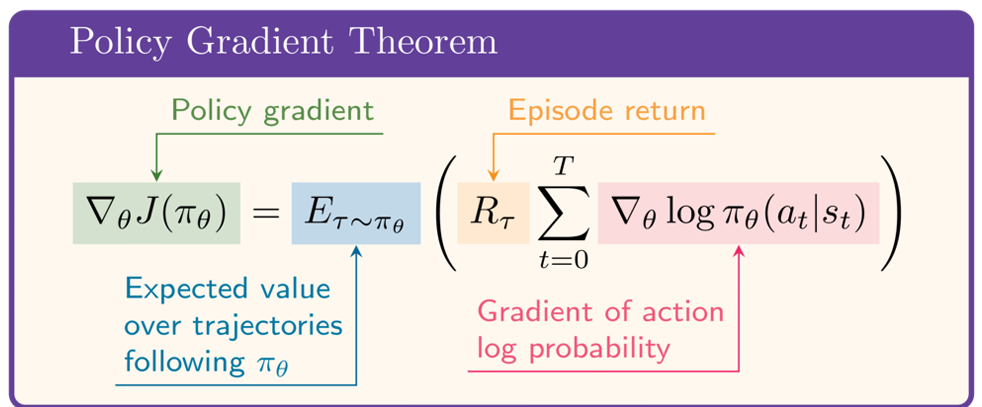
  + for implementation, we multiply the episode return (R) by the sum of log($\pi_{\theta}$) for each action taken for each state during the episode
  + intuition is to increase probability of all actions taken in a good episode or resulting in big rewards
+ differences of policy methods with DQN
  + Reinforece: based on Monte-Carlo, not temporal difference
  + update at the end of the episode, not at every step (no replay buffer)
  + can update after several episodes instead
  + No value function and target network
  + no epsilon-greediness
  + no experience replay
+ Advantage Actor Critic (A2C)
   + REINFORCE limitations:
     + High variance
     + Poor sample efficiency
   + Actor Critic methods introduce a critic network, enabling Temporal Difference learning
     + citic is similar to state function that calucates the value of given state
   + Purpose of Actor and Critic networks
     + Critic aims to minize the TD error
     + Actor amis to maximize the log probability of actions resulting in large positive TD error
       + to guide the training towards positive overall rewards including all state values on
     + 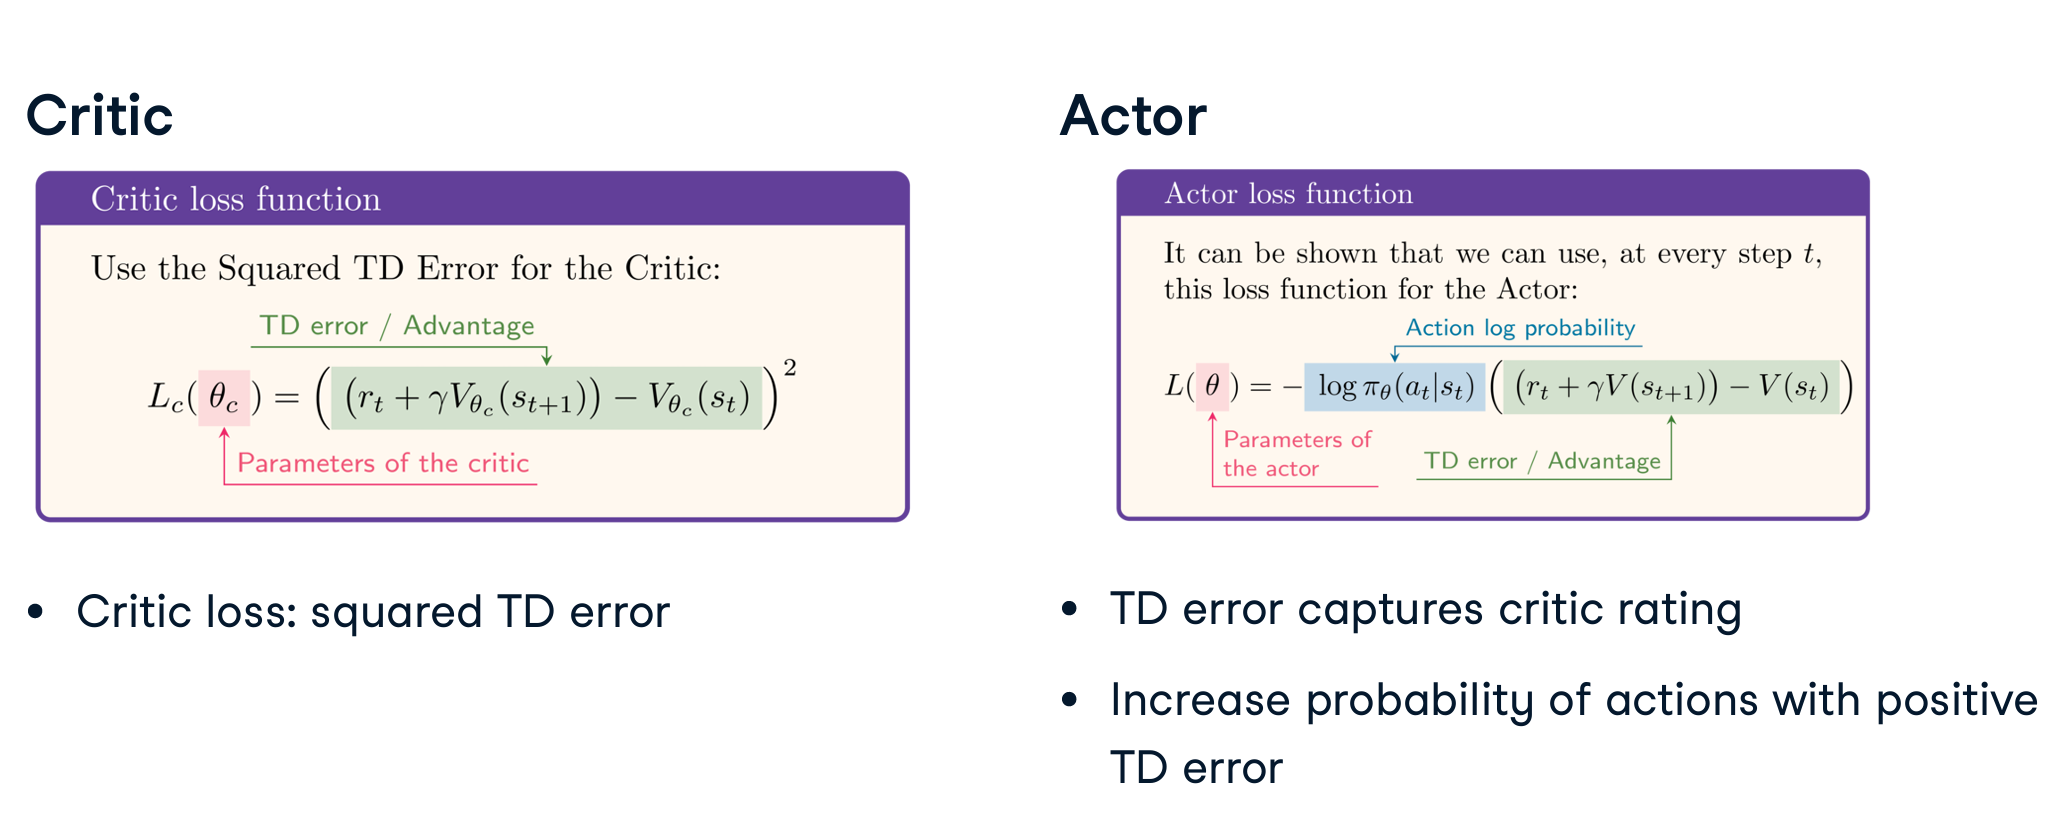
   + A2C dynamics:
     + At every step:
       + Actor chooses action (same as policy network in REINFORCE)
       + Critic observes reward and state
       + Critic evaluates TD Error
       + Actor and Critic use TD Error to update weights
       + Updated Actor observes new state     

In [12]:
from torch.distributions import Categorical 
import gymnasium as gym
import torch.nn as nn
import torch.optim as optim 
import numpy as np
import torch

# define PolicyNetwork to predict the probabilities of all actions
# depending on the prob dist, we can sample the actions
class PolicyNetwork(nn.Module): 
    def __init__(self, state_size, action_size, device): 
        super().__init__() 
        self.fc1 = nn.Linear(state_size, 64) 
        self.fc2 = nn.Linear(64, 64) 
        self.fc3 = nn.Linear(64, action_size)
        self.device = device
        self.to(self.device)
        
    def forward(self, state): 
        x = torch.relu(self.fc1(torch.tensor(state).to(self.device))) 
        x = torch.relu(self.fc2(x)) 
        action_probs = torch.softmax(self.fc3(x), dim=-1) 
        return action_probs  
        
def select_action(policy_network, state): 
    action_probs = policy_network(state)  
    action_dist = Categorical(action_probs) 
    action = action_dist.sample() 
    log_prob = action_dist.log_prob(action) 
    return action.item(), log_prob.reshape(1) 

env = gym.make("LunarLander-v3")
state, info = env.reset()
state_size, action_size = env.observation_space.shape[0], env.action_space.n
device = "cuda" if torch.cuda.is_available() else "cpu"

policy_network = PolicyNetwork(state_size, action_size, device)
action_probs = policy_network(state) 
print('Action probabilities:', action_probs) 


state, info = env.reset()
action, log_prob = select_action(policy_network, state) 
print(f"action={action}, log_prob={log_prob}")

Action probabilities: tensor([0.2272, 0.2516, 0.2348, 0.2864], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
action=3, log_prob=tensor([-1.2612], device='cuda:0', grad_fn=<ViewBackward0>)


In [13]:
def ReinforceTrain(env, episode_num, device, gamma=0.9):
    
    state_size, action_size = env.observation_space.shape[0], env.action_space.n
    policy_network = PolicyNetwork(state_size, action_size, device)
    
    optimizer = optim.Adam(policy_network.parameters(), lr=0.0001)
    
    for episode in range(episode_num):        
        state, info = env.reset()
        done = False
        step = 0 
        episode_log_probs = torch.tensor([]).to(device)  
        R = 0 
        while not done: 
            step += 1 
            action, log_prob = select_action(policy_network, state) 
            next_state, reward, terminated, truncated, _ = env.step(action) 
            done = terminated or truncated 
            R += (gamma ** step) * reward 
            episode_log_probs = torch.cat((episode_log_probs, log_prob)) 
            state = next_state 
        loss = - R * episode_log_probs.sum() 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print(f"episode: {episode} with episode loss is {loss}")    

device = "cuda" if torch.cuda.is_available() else "cpu"
ReinforceTrain(env, 10, device)        

episode: 0 with episode loss is -576.4622802734375
episode: 1 with episode loss is 23.480710983276367
episode: 2 with episode loss is -977.4302368164062
episode: 3 with episode loss is 427.3435974121094
episode: 4 with episode loss is -1119.7391357421875
episode: 5 with episode loss is 75.13967895507812
episode: 6 with episode loss is -1240.1888427734375
episode: 7 with episode loss is -488.44866943359375
episode: 8 with episode loss is -834.0663452148438
episode: 9 with episode loss is 257.3697509765625


In [14]:
# given a state, predicts its value
class Critic(nn.Module): 
    
    def __init__(self, state_size, device): 
        super(Critic, self).__init__() 
        self.fc1 = nn.Linear(state_size, 64) 
        self.fc2 = nn.Linear(64, 1) 
        self.device = device
        self.to(self.device)
    
    def forward(self, state): 
        x = torch.relu(self.fc1(torch.tensor(state).to(self.device)))
        value = self.fc2(x) 
        return value 

device = "cuda" if torch.cuda.is_available() else "cpu"
critic_network = Critic(state_size, device)
print(critic_network)

def select_action(policy_network, state): 
    action_probs = policy_network(state)  
    action_dist = Categorical(action_probs) 
    action = action_dist.sample() 
    log_prob = action_dist.log_prob(action) 
    return action.item(), log_prob.reshape(1) 


def calculate_losses(critic_network, action_log_prob, reward, state, next_state, done, gamma=0.9): 
    # Critic provides the state value estimates 
    value = critic_network(state)  
    next_value = critic_network(next_state) 
    td_target = (reward + gamma * next_value * (1-done)) 
    td_error = td_target - value 
    
    # Apply formulas for actor and critic losses 
    actor_loss = -action_log_prob * td_error.detach() 
    critic_loss = td_error ** 2 
    return actor_loss, critic_loss

def A2C(env, episode_num, device, gamma=0.9):
    state_size, action_size = env.observation_space.shape[0], env.action_space.n
    
    actor = PolicyNetwork(state_size, action_size, device)
    critic = Critic(state_size, device)
    actor_optimizer = optim.Adam(actor.parameters(), lr=0.0001)
    critic_optimizer = optim.Adam(critic.parameters(), lr=0.0001)
    
    for episode in range(episode_num):
        state, info = env.reset()
        episode_reward = 0
        done = False
        step = 0
        while not done: 
            step += 1
            # Select action 
            action, action_log_prob = select_action(actor, state)  
            next_state, reward, terminated, truncated, _ = env.step(action) 
            done = terminated or truncated  
            # Calculate losses 
            actor_loss, critic_loss = calculate_losses(critic, action_log_prob, reward, state, next_state, done)  
            # Update actor 
            actor_optimizer.zero_grad(); actor_loss.backward(); actor_optimizer.step()  
            # Update critic 
            critic_optimizer.zero_grad(); critic_loss.backward(); critic_optimizer.step() 
            episode_reward += reward
            state = next_state 
        print(f"episode: {episode}, episode reward: {episode_reward}, steps: {step}")   

device = "cuda" if torch.cuda.is_available() else "cpu"
A2C(env, 10, device)        

Critic(
  (fc1): Linear(in_features=8, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
)
episode: 0, episode reward: -74.29714981953214, steps: 73
episode: 1, episode reward: -99.04227997728962, steps: 62
episode: 2, episode reward: -449.8083420510028, steps: 126
episode: 3, episode reward: -116.08075271588135, steps: 105
episode: 4, episode reward: -298.7898252106437, steps: 79
episode: 5, episode reward: -46.691874729992236, steps: 149
episode: 6, episode reward: -91.29822964607865, steps: 97
episode: 7, episode reward: -374.5829268390268, steps: 109
episode: 8, episode reward: -292.5058493173409, steps: 78
episode: 9, episode reward: -235.95448959863404, steps: 121


In [15]:
def A2C_batch(env, episode_num, device, rollout_length = 10, gamma=0.9):
    state_size, action_size = env.observation_space.shape[0], env.action_space.n

    actor_losses = torch.tensor([]).to(device)
    critic_losses = torch.tensor([]).to(device)
    
    actor = PolicyNetwork(state_size, action_size, device)
    critic = Critic(state_size, device)
    actor_optimizer = optim.Adam(actor.parameters(), lr=0.0001)
    critic_optimizer = optim.Adam(critic.parameters(), lr=0.0001)
    
    for episode in range(episode_num):
        state, info = env.reset()
        episode_reward = 0
        done = False
        step = 0
        while not done: 
            step += 1
            # Select action 
            action, action_log_prob = select_action(actor, state)  
            next_state, reward, terminated, truncated, _ = env.step(action) 
            done = terminated or truncated  
            # Calculate losses 
            actor_loss, critic_loss = calculate_losses(critic, action_log_prob, reward, state, next_state, done)

            # update losses tensors
            actor_losses = torch.cat((actor_losses, actor_loss))
            critic_losses = torch.cat((critic_losses, critic_loss))

            # update actor and critic in batch mode 
            if len(actor_losses) >= rollout_length: 
                actor_loss_batch = actor_losses.mean() 
                critic_loss_batch = critic_losses.mean()
                
                # Update actor 
                actor_optimizer.zero_grad(); actor_loss_batch.backward(); actor_optimizer.step()  
                # Update critic 
                critic_optimizer.zero_grad(); critic_loss_batch.backward(); critic_optimizer.step()
                actor_losses = torch.tensor([]).to(device)
                critic_losses = torch.tensor([]).to(device)
            episode_reward += reward
            state = next_state 
        print(f"episode: {episode}, episode reward: {episode_reward}, steps: {step}")
        
device = "cuda" if torch.cuda.is_available() else "cpu"
A2C_batch(env, 10, device)   

episode: 0, episode reward: -232.76267369100435, steps: 74
episode: 1, episode reward: -146.24122036725234, steps: 77
episode: 2, episode reward: -79.83204600032047, steps: 64
episode: 3, episode reward: -198.3840619415406, steps: 66
episode: 4, episode reward: -221.85780834096107, steps: 86
episode: 5, episode reward: -142.74636783483598, steps: 104
episode: 6, episode reward: -253.51202580977775, steps: 85
episode: 7, episode reward: -105.38100256067749, steps: 112
episode: 8, episode reward: -98.67528160078194, steps: 76
episode: 9, episode reward: -137.73055733978214, steps: 63


#### Proximal Policy Optimization (PPO)
+ A2C has the following problems
  + Based on volatile estimates
  + Can be large and unstable
  + May harm performance
  + we can use A2C in batch update mode to gain a little bit stability
+ PPO
  + sets limits on the size of each polciy update
  + improves stability
  + PPO set objective function based on the ratio between probability of an action under new and old policies
  + ratio = torch.exp(action_log_prob - old_action_log_prob.detach())
  + clip the ratio to avoid big change by torch.clamp(ratio, 1-epsilon, 1+epsilon)
  + the loss is calculated using the torch.min(ratio * td_error, clipped_ratio * td_error)
``` python
   value = critic_network(state) 
   next_value = critic_network(next_state)
   td_target = (reward + gamma * next_value * (1-done))
   td_error = td_target - value
```   
  + entropy bonus
    + policy gradient algorithms may collapse into deterministic policies
    + adding entropy bonus. Entropy measures uncertainty of a distribution
    + H(X) = -sum\[p(x) $log_2$p(x)\]
  + PPO with batch update
    +  The previous PPO algorithm
      + updating at each step: not taking full advantage of PPO objective function
      + At each step, θ actually coincides with $θ_{old}$ .
    + Full PPO implementations decouple:
       + Parameter updates (minibatches)
       + minibatches are subset of rollouts
       + Policy updates (rollouts)
  

In [16]:
# PPO
def calculate_ratios(action_log_prob, action_log_prob_old, epsilon=0.2): 
    prob = action_log_prob.exp() 
    prob_old = action_log_prob_old.exp() 
    prob_old_detached = prob_old.detach() 
    ratio = prob / prob_old_detached 
    clipped_ratio = torch.clamp(ratio, 1-epsilon, 1+epsilon) 
    return (ratio, clipped_ratio) 

def calculate_losses(critic_network,  
                     action_log_prob,                
                     action_log_prob_old, 
                     reward, state, next_state, 
                     done, gamma=0.9 
                     ): 
    # calculate TD error (same as A2C) 
    value = critic_network(state) 
    next_value = critic_network(next_state) 
    td_target = (reward + gamma * next_value * (1-done)) 
    td_error = td_target - value 

    ratio, clipped_ratio = calculate_ratios(action_log_prob, action_log_prob_old)  
    surr1 = ratio * td_error.detach()  
    surr2 = clipped_ratio * td_error.detach()  
    objective = torch.min(surr1, surr2)  
    actor_loss = -objective  
    critic_loss = td_error ** 2 
 
    return actor_loss, critic_loss

def select_action(policy_network, state): 
    action_probs = policy_network(state) 
    action_dist = Categorical(action_probs) 
    action = action_dist.sample() 
    log_prob = action_dist.log_prob(action)
    
    # Obtain the entropy of the policy 
    entropy = action_dist.entropy()  
    return (action.item(), log_prob.reshape(1), entropy) 

def PPO(env, episode_num, device, c_entropy=0.01, gamma=0.9):
    
    state_size, action_size = env.observation_space.shape[0], env.action_space.n
    
    actor = PolicyNetwork(state_size, action_size, device)
    critic = Critic(state_size, device)
    actor_optimizer = optim.Adam(actor.parameters(), lr=0.0001)
    critic_optimizer = optim.Adam(critic.parameters(), lr=0.0001)

    for episode in range(10): 
        state, info = env.reset() 
        done = False 
        episode_reward = 0
        step = 0
        while not done:
            step += 1
            action, action_log_prob, entropy = select_action(actor, state) 
            next_state, reward, terminated, truncated, _ = env.step(action) 
            done = terminated or truncated 
            actor_loss, critic_loss = calculate_losses(critic, action_log_prob, action_log_prob, 
                                                       reward, state, next_state, done) 
            actor_loss -= c_entropy * entropy 
            actor_optimizer.zero_grad()
            actor_loss.backward()
            actor_optimizer.step() 
            critic_optimizer.zero_grad()
            critic_loss.backward()
            critic_optimizer.step() 

            episode_reward += reward
            state = next_state 
        print(f"episode: {episode}, episode reward: {episode_reward}, steps: {step}")   

device = "cuda" if torch.cuda.is_available() else "cpu"
PPO(env, 10, device)         


episode: 0, episode reward: -278.4448207796189, steps: 93
episode: 1, episode reward: -172.59228154054875, steps: 132
episode: 2, episode reward: -64.74891613501947, steps: 83
episode: 3, episode reward: -277.03146200708903, steps: 71
episode: 4, episode reward: -166.51504771244305, steps: 105
episode: 5, episode reward: -341.1493127293045, steps: 90
episode: 6, episode reward: -15.336032779188244, steps: 105
episode: 7, episode reward: -165.8539457192905, steps: 81
episode: 8, episode reward: -136.18533332804256, steps: 70
episode: 9, episode reward: -212.3855983964729, steps: 114


### Run simulation of environment using policy
#### convert learned model to policy
+ choose the max value action
#### apply policy to LunarLander env
+ apply policy to LunarLander environment
+ save the plot of the states generated by env.render() to vedio file

In [9]:
def policy(state, q_network):
    with torch.no_grad():
        q_values = q_network(state)
    return torch.argmax(q_values).item()

In [11]:
env = gym.make("LunarLander-v3", render_mode="rgb_array")
frames = []

obs, _ = env.reset()
done = False

while not done:
    frames.append(env.render())
    action = policy(obs, q_network)
    obs, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated

env.close()

# play the video

import imageio

imageio.mimsave("lander.gif", frames, fps=30)

### Hyperparameter tuning by Optuna
+ hyperparameters in DLR:
   + Large number of hyperparameters in DRL algorithms
   + Can have large effect on performance
   + Search complexity grows with number of hyperparameters
+ how to optimize hyperparameters
   + objective: maximize average cumulative rewards
   + Hyperparameter search techniques:
      + Trial and error by hand
      + Grid search
      + Random search
      + Dedicated algorithms
+ Optuna workflow:
   + define the hyperparameters of interest using optuna.trial.Trial by specifying parameter type and range
      + float
      + integer
      + categorical 
   + define the metric(s) to optimize by setting the equation/formula of objective function
   + Instantiate an Optuna study and pass the objective function
   + Let Optuna iterate over trials

In [17]:
import optuna
import sqlite3
import sys
import os

class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

def objective(trial: optuna.trial.Trial) -> float:
    # Hyperparameters x and y between -10 and 10 
    x = trial.suggest_float('x', -10, 10) 
    y = trial.suggest_float('y', -10, 10) 
    
    # Return the metric to minimize 
    return (x - 2) ** 2 + 1.2 * (y + 3) ** 2

study = optuna.create_study(storage="sqlite:///DRL.db", study_name="my_study", load_if_exists=True)
with HiddenPrints():
    study.optimize(objective, n_trials=100)

[I 2025-10-26 14:11:23,794] Using an existing study with name 'my_study' instead of creating a new one.
[I 2025-10-26 14:11:23,999] Trial 300 finished with value: 1.1353876673861762 and parameters: {'x': 1.9071574974081624, 'y': -2.0309936631189913}. Best is trial 183 with value: 0.0028247917844460278.
[I 2025-10-26 14:11:24,124] Trial 301 finished with value: 1.0389188867781485 and parameters: {'x': 2.4308876158650996, 'y': -3.843235212970576}. Best is trial 183 with value: 0.0028247917844460278.
[I 2025-10-26 14:11:24,244] Trial 302 finished with value: 0.664763245594292 and parameters: {'x': 1.202757666894007, 'y': -3.1559057084105775}. Best is trial 183 with value: 0.0028247917844460278.
[I 2025-10-26 14:11:24,353] Trial 303 finished with value: 39.893256644939115 and parameters: {'x': 3.4954770656723015, 'y': -8.601845305417022}. Best is trial 183 with value: 0.0028247917844460278.
[I 2025-10-26 14:11:24,466] Trial 304 finished with value: 0.26894778343804726 and parameters: {'x':

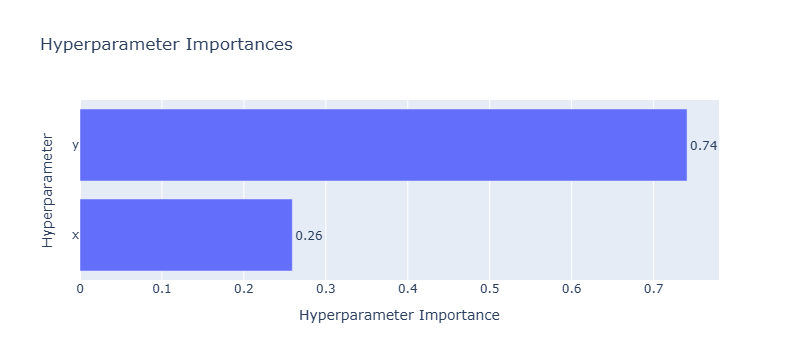

In [18]:
optuna.visualization.plot_param_importances(study) 

In [19]:
import optuna
loaded_study = optuna.load_study(study_name="my_study", storage="sqlite:///DRL.db") 
fig = optuna.visualization.plot_param_importances(loaded_study)
fig.show()

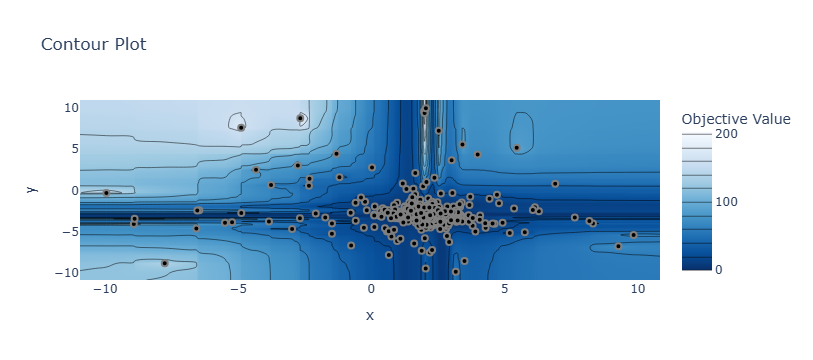

In [20]:
optuna.visualization.plot_contour(loaded_study)